<a href="https://colab.research.google.com/github/npgeorge/NHL_Project/blob/master/NHL_Data_Project_Team_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NHL Data Project


#Answers

Choose your target. Which column in your tabular dataset will you predict?

I will predict on the "won" column for the Boston Bruins first, and apply that model to all teams.

Is your problem regression or classification?

Regression, win or loss is binary. I could try classification as well. 

How is your target distributed?

Regression: Is the target right-skewed? If so, you may want to log transform the target. TBD. 


Choose which observations you will use to train, validate, and test your model.

    - Are some observations outliers? Will you exclude them? TBD
    - Will you do a random split or a time-based split? Random. 


Choose your evaluation metric(s).
    - Classification: Is your majority class frequency > 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
- Begin to clean and explore your data.
- Begin to choose which features, if any, to exclude. Would some features "leak" future information?

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install plotly_express

#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly_express as px
import sklearn


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
file_path = '/content/gdrive/My Drive/Lambda School/NHL Project/game_teams_stats.csv'

In [0]:
df = pd.read_csv(file_path)

In [6]:
df.shape

(22868, 15)

In [7]:
df.head(1)

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
0,2011030221,1,away,False,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7


In [8]:
df.tail()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
22863,2018030415,6,home,False,REG,Bruce Cassidy,1,39,43,2,3,0,40.6,4,11
22864,2018030416,6,away,True,REG,Bruce Cassidy,5,32,27,10,4,1,41.3,4,10
22865,2018030416,19,home,False,REG,Craig Berube,1,29,29,20,4,0,58.7,12,11
22866,2018030417,19,away,True,REG,Craig Berube,4,20,36,2,0,0,49.0,7,8
22867,2018030417,6,home,False,REG,Bruce Cassidy,1,33,28,0,1,0,51.0,13,6


In [9]:
df.dtypes

game_id                     int64
team_id                     int64
HoA                        object
won                          bool
settled_in                 object
head_coach                 object
goals                       int64
shots                       int64
hits                        int64
pim                         int64
powerPlayOpportunities      int64
powerPlayGoals              int64
faceOffWinPercentage      float64
giveaways                   int64
takeaways                   int64
dtype: object


    Game IDs
    The first 4 digits identify the season of the game (ie. 2017 for the 2017-2018 season). 
    The next 2 digits give the type of game, where 01 = preseason, 02 = regular season, 
    03 = playoffs, 04 = all-star. 
    The final 4 digits identify the specific game number. 
    For regular season and preseason games, this ranges from 0001 to the 
    number of games played. (1271 for seasons with 31 teams (2017 and onwards) 
    and 1230 for seasons with 30 teams). 
    For playoff games, the 2nd digit of the specific number gives the round of the playoffs, 
    the 3rd digit specifies the matchup, and the 4th digit specifies the game (out of 7).


In [0]:
#wrangle function to separate the game_id column into season, game_type, and game_number
def wrangle(X):
  
    #breaking out game_id
    X['season'] = X.game_id.astype(str).str[:4].astype(int)
    #regular season and playoffs
    X['game_type'] = X.game_id.astype(str).str[4:6].astype(int)
    #to allow ordering of games
    X['game_number'] = X.game_id.astype(str).str[6:].astype(int)

    # return the wrangled dataframe
    return X

df = wrangle(df)

In [11]:
#sorting by game_id test
df.sort_values('game_id')

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,season,game_type,game_number
22156,2010020001,8,away,False,REG,Jacques Martin,2,28,34,10,3,0,53.5,7,7,2010,2,1
22157,2010020001,10,home,True,REG,Ron Wilson,3,24,27,6,5,0,46.5,16,6,2010,2,1
21451,2010020002,5,home,False,REG,Dan Bylsma,2,31,32,10,5,1,60.7,11,9,2010,2,2
21450,2010020002,4,away,True,REG,Peter Laviolette,3,27,34,12,4,1,39.3,9,1,2010,2,2
19251,2010020003,30,home,False,REG,Todd Richards,3,29,19,10,5,2,61.2,11,8,2010,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22863,2018030415,6,home,False,REG,Bruce Cassidy,1,39,43,2,3,0,40.6,4,11,2018,3,415
22864,2018030416,6,away,True,REG,Bruce Cassidy,5,32,27,10,4,1,41.3,4,10,2018,3,416
22865,2018030416,19,home,False,REG,Craig Berube,1,29,29,20,4,0,58.7,12,11,2018,3,416
22866,2018030417,19,away,True,REG,Craig Berube,4,20,36,2,0,0,49.0,7,8,2018,3,417


In [12]:
#seasons conditional
season_2010to2011 = (df['season'] == 2010)
season_2011to2012 = (df['season'] == 2011)
season_2012to2013 = (df['season'] == 2012)
season_2013to2014 = (df['season'] == 2013)
season_2014to2015 = (df['season'] == 2014)
season_2015to2016 = (df['season'] == 2015)
season_2016to2017 = (df['season'] == 2016)
season_2017to2018 = (df['season'] == 2017)
season_2018to2019 = (df['season'] == 2018)

#passing in each condition
df_10_11 = df[season_2010to2011]
df_11_12 = df[season_2011to2012]
df_12_13 = df[season_2012to2013]
df_13_14 = df[season_2013to2014]
df_14_15 = df[season_2014to2015]
df_15_16 = df[season_2015to2016]
df_16_17 = df[season_2016to2017]
df_17_18 = df[season_2017to2018]
df_18_19 = df[season_2018to2019]

#seasons can vary depending on playoff games
#2012 to 2013 season doesn't make sense... hmmm, a lot less data this year
print('2010-2011 Season games, data collected: ', df_10_11.shape)
print('2011-2012 Season games, data collected: ', df_11_12.shape)
print('2012-2013 Season games, data collected: ', df_12_13.shape)
print('2013-2014 Season games, data collected: ', df_13_14.shape)
print('2014-2015 Season games, data collected: ', df_14_15.shape)
print('2015-2016 Season games, data collected: ', df_15_16.shape)
print('2016-2017 Season games, data collected: ', df_16_17.shape)
print('2017-2018 Season games, data collected: ', df_17_18.shape)
print('2018-2019 Season games, data collected: ', df_18_19.shape)

2010-2011 Season games, data collected:  (2638, 18)
2011-2012 Season games, data collected:  (2632, 18)
2012-2013 Season games, data collected:  (1612, 18)
2013-2014 Season games, data collected:  (2646, 18)
2014-2015 Season games, data collected:  (2638, 18)
2015-2016 Season games, data collected:  (2642, 18)
2016-2017 Season games, data collected:  (2634, 18)
2017-2018 Season games, data collected:  (2710, 18)
2018-2019 Season games, data collected:  (2716, 18)


In [0]:
#checking out 2012 data, may just drop it or skip it
#df.loc[(df['game_id'] >= 2012020000) & (df['game_id'] <= 2012031300)]

In [0]:
#checking through 2012 season
#df.loc[df['game_id'] >= 2012020570 & df['game_id'] <= 2012021271]
#reg_season = ((df['game_id'] >= 2012020000) & (df['game_id'] <= 2012021300))
#playoffs = ((df['game_id'] >= 2012030000) & (df['game_id'] <= 2012031300))

#a_range = df[a]['game_id'].max() - df[a]['game_id'].min()
#b_range = df[b]['game_id'].max() - df[b]['game_id'].min()

#print(a_range)
#print(b_range)

In [15]:
#bruins
#if a model works for one team, it *could* work broadly for others
#this may turn out to be a bad assumption
#this filter returns the df for the Bruins
#or statement for home and away games

bruins_id_condition = df['team_id'] == 6
df_bruins = df[bruins_id_condition]
df_bruins.shape

(812, 18)

In [16]:
#bruins 13 to 14 season
bruins_id_condition_13_14 = df_13_14['team_id'] == 6
df_bruins_13_14 = df_13_14[bruins_id_condition_13_14]
df_bruins_13_14.shape

(94, 18)

In [0]:
#sort the season to be in order of the games played
#want to have a streak feature... wins in a row, losses in a row
#df_bruins_13_14 = df_bruins_13_14.sort_values(by=['game_number'])

In [0]:
#different plots for visualizations
#px.scatter(df_bruins_13_14, x='shots', y='goals', marginal_x='box', marginal_y='violin', trendline='ols')
#px.scatter(df_bruins_13_14, x='hits', y='goals', marginal_x='box', marginal_y='violin')
#px.scatter(df_bruins_13_14, x='giveaways', y='goals', marginal_x='box', marginal_y='violin')

In [19]:
#baseline, can we beat the Bruins baseline target?
baseline_target = 'won'
y_baseline = df_bruins[baseline_target]
y_baseline.value_counts(normalize=True) 

True     0.57266
False    0.42734
Name: won, dtype: float64

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
#train, test
train, test = train_test_split(df_bruins, 
                               train_size=0.80, 
                               test_size=0.20,
                               stratify=df_bruins['won'], 
                               random_state=42)
train.shape, test.shape

((649, 18), (163, 18))

In [21]:
#train, val
train, val = train_test_split(train, 
                              train_size=0.80, 
                              test_size=0.20, 
                              stratify=train['won'], 
                              random_state=42)
train.shape, val.shape

((519, 18), (130, 18))

In [22]:
train.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,season,game_type,game_number
5575,2014021170,6,home,True,SO,Claude Julien,1,50,29,4,3,0,52.5,11,5,2014,2,1170
4386,2012020615,6,away,False,REG,Claude Julien,2,30,16,21,3,0,56.1,6,3,2012,2,615
357,2012030142,6,home,False,REG,Claude Julien,2,41,35,13,1,0,64.5,4,4,2012,3,142
40,2012030223,6,away,True,REG,Claude Julien,2,34,28,6,0,0,61.8,10,7,2012,3,223
9760,2016020430,6,away,True,OT,Claude Julien,2,29,34,17,1,0,52.5,16,4,2016,2,430


In [0]:
#target and features
target = 'won'

#drop target 
train_features = train.drop(columns=[target,'team_id', 'game_id', 'powerPlayGoals', 'game_number', 'settled_in', 'head_coach', 'season'])

#numeric features
num_feat = train_features.select_dtypes(include='number').columns.tolist()

#series with cardinality of non-numeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

#list with cardinality less than 10
cat_feat = cardinality[cardinality <= 10].index.tolist()

# Combine the lists 
features = num_feat + cat_feat

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [25]:
X_train.shape

(519, 10)

In [26]:
#with XG Boost
import category_encoders as ce
import xgboost
from xgboost import XGBClassifier
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import joblib
from joblib import dump

pipeline_xgb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=15, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline_xgb.fit(X_train, y_train)
print('Training Accuracy', pipeline_xgb.score(X_train, y_train))
print('Validation Accuracy:', pipeline_xgb.score(X_val, y_val))

#predict on test
y_pred_xgb = pipeline_xgb.predict(X_test)

#Test Accuracy score
print('Test Accuracy for XG Boost', accuracy_score(y_test, y_pred_xgb))

Training Accuracy 0.7726396917148363
Validation Accuracy: 0.8153846153846154
Test Accuracy for XG Boost 0.7607361963190185


In [27]:
#printing versions to download locally
print(f'joblib=={joblib.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'xgboost=={xgboost.__version__}')

joblib==0.14.1
category_encoders==2.1.0
scikit-learn==0.22.1
xgboost==0.90


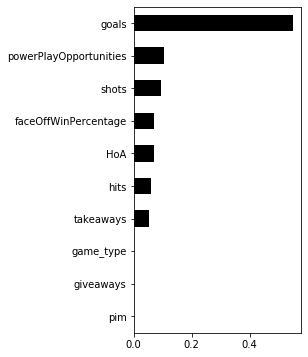

In [28]:
#feature importance for X val
import matplotlib.pyplot as plt
model = pipeline_xgb.named_steps['xgbclassifier']
encoder = pipeline_xgb.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(3,6))
importances.sort_values().plot.barh(color='black');

In [29]:
#random forest classifier pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, 
                           n_jobs=-1, 
                           min_samples_leaf=1, 
                           max_depth=10, 
                           class_weight='balanced',
                           max_features=7, 
                           )
)

# Fit on train
pipeline.fit(X_train, y_train)

# Predict on Test Data
y_pred_rfc = pipeline.predict(X_test)

# Score on Train/Val
print('Training Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))
print('Test Accuracy for Random Forest', accuracy_score(y_test, y_pred_rfc))

Training Accuracy 0.9961464354527938
Validation Accuracy 0.7769230769230769
Test Accuracy for Random Forest 0.7361963190184049


In [69]:
#Linear model that beats baseline
#logistic regression
from sklearn.linear_model import LogisticRegression

pipeline_lin = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    #Ridge(alpha=1.0)
    LogisticRegression(solver='lbfgs')

)

# Fit on train
pipeline_lin.fit(X_train, y_train)

#score on train
pipeline_lin.score(X_train, y_train)

# Predict on Test Data
y_pred_lin = pipeline_lin.predict(X_test)

# Score on Train/Val
print('Training Accuracy', pipeline_lin.score(X_train, y_train))
print('Validation Accuracy', pipeline_lin.score(X_val, y_val))
print('Test Accuracy', pipeline_lin.score(X_test, y_test))

Training Accuracy 0.7610789980732178
Validation Accuracy 0.7846153846153846
Test Accuracy 0.7607361963190185


In [33]:
#setting up ELI5 for XGBOOST
pipeline_pi = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = pipeline_pi.fit_transform(X_train)
X_val_transformed = pipeline_pi.transform(X_val)


model_pi = XGBClassifier(n_estimators=15, random_state=42, n_jobs=-1)
model_pi.fit(X_train_transformed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=15, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [34]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model_pi,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=None,
                                              n_estimators=15, n_jobs=-1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=42, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                    

In [35]:
permuter.feature_importances_

array([ 0.29384615,  0.01076923,  0.00153846,  0.        ,  0.00461538,
        0.00615385,  0.        , -0.00153846,  0.        ,  0.        ])

In [36]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

Weight,Feature
0.2938 ± 0.0762,goals
0.0108 ± 0.0075,shots
0.0062 ± 0.0115,faceOffWinPercentage
0.0046 ± 0.0075,powerPlayOpportunities
0.0015 ± 0.0062,hits
0 ± 0.0000,HoA
0 ± 0.0000,game_type
0 ± 0.0000,giveaways
0 ± 0.0000,pim
-0.0015 ± 0.0115,takeaways


In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


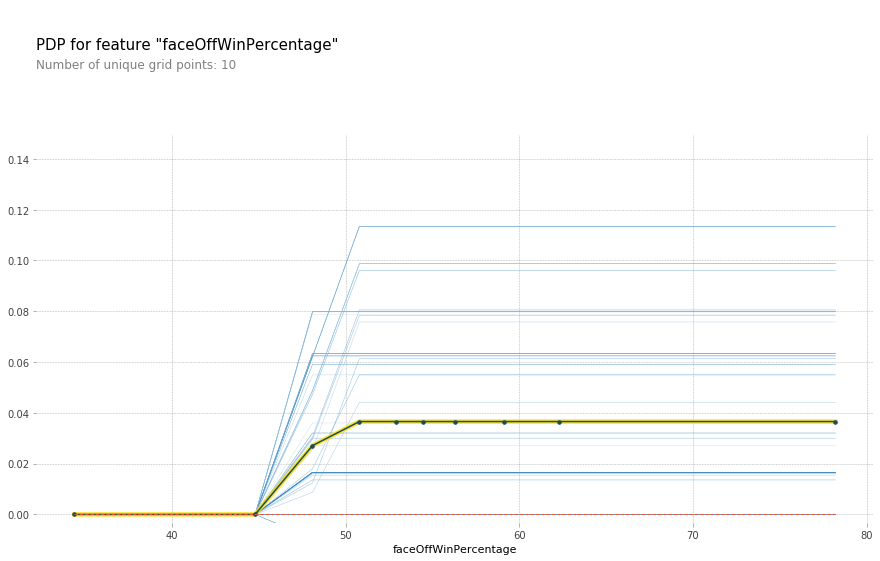

In [39]:
feature='faceOffWinPercentage'

pdp_faceoffs = pdp_isolate(
    model = pipeline_xgb,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature
)

pdp_plot(pdp_faceoffs, feature_name=feature,  plot_lines=True, frac_to_plot=100);

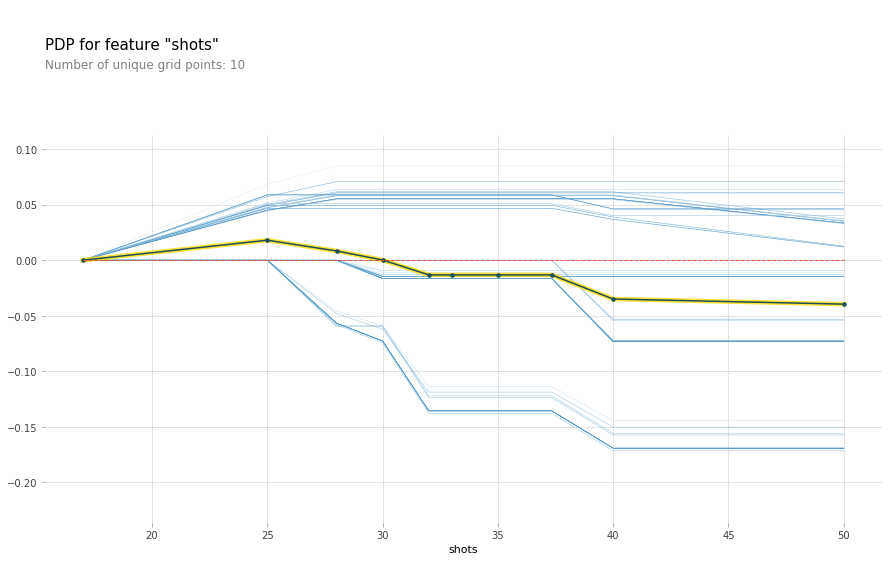

In [40]:
feature='shots'

pdp_shots = pdp_isolate(
    model = pipeline_xgb,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature
)

pdp_plot(pdp_shots, feature_name=feature,  plot_lines=True, frac_to_plot=100);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


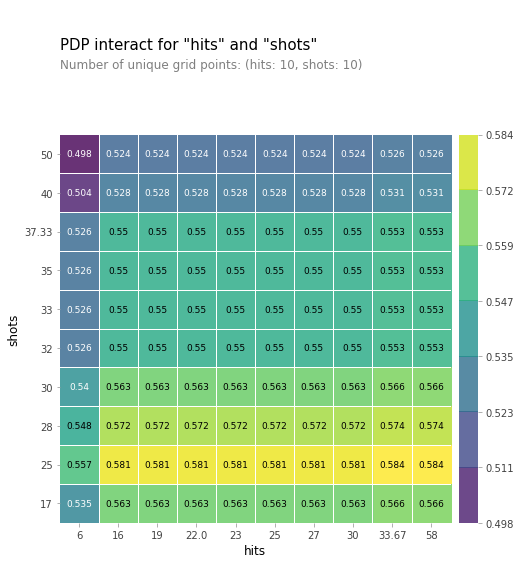

In [41]:
#PDP two features
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features=['hits','shots']

interaction = pdp_interact(
    model=pipeline_xgb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);


#ROC/AUC Score

In [42]:
#for ROC/AUC from class.. 
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.83033	validation_1-auc:0.863394
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.83033	validation_1-auc:0.863394
[2]	validation_0-auc:0.838118	validation_1-auc:0.864485
[3]	validation_0-auc:0.844071	validation_1-auc:0.870303
[4]	validation_0-auc:0.845573	validation_1-auc:0.870061
[5]	validation_0-auc:0.851094	validation_1-auc:0.871879
[6]	validation_0-auc:0.852686	validation_1-auc:0.872121
[7]	validation_0-auc:0.85217	validation_1-auc:0.874788
[8]	validation_0-auc:0.853922	validation_1-auc:0.874424
[9]	validation_0-auc:0.854134	validation_1-auc:0.874909
[10]	validation_0-auc:0.854104	validation_1-auc:0.875394
[11]	validation_0-auc:0.858169	validation_1-auc:0.876
[12]	validation_0-auc:0.8592	validation_1-auc:0.876
[13]	validation_0-auc:0.861286	validation_1-auc:0.876606
[14]	validation_0-auc:0.863052	validation_1-auc:0.875515
[15]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [43]:
from sklearn.metrics import roc_auc_score
X_test_proc = processor.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_test_proc)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba))

Test ROC AUC for class 1:
0.8298771121351767


In [44]:
#ROC/AUC
from sklearn.metrics import roc_curve

# Probability for last class
y_pred_proba = pipeline_xgb.predict_proba(X_val)[:, -1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

#data frame
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,1.846692
1,0.000000,0.013333,0.846692
2,0.000000,0.066667,0.843816
3,0.000000,0.080000,0.833727
4,0.018182,0.120000,0.832790
5,0.018182,0.160000,0.830656
6,0.018182,0.226667,0.825583
7,0.018182,0.253333,0.823048
8,0.018182,0.266667,0.821955
9,0.018182,0.320000,0.811231


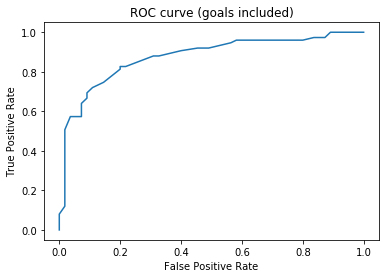

In [45]:
plt.plot(fpr, tpr)
plt.title('ROC curve (goals included)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [46]:
#shap #1
import shap
row = X_test.iloc[[60]]
explainer=shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row,
    link='logit'             
)

In [47]:
#confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

print(confusion_matrix(y_test, y_pred_xgb))
print(unique_labels(y_test))

[[52 18]
 [21 72]]
[False  True]


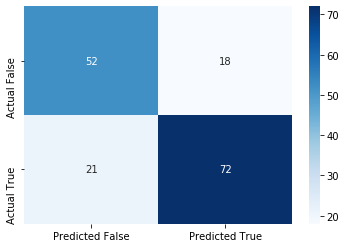

In [48]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
  labels = unique_labels(y_true)
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]
  df = pd.DataFrame(confusion_matrix(y_true, y_pred),
                    columns = columns,
                    index = index)
  return sns.heatmap(df, annot=True, fmt='d', cmap='Blues')

plot_confusion_matrix(y_test, y_pred_xgb);

#Dash App Interface

In [49]:
import joblib
from joblib import dump
dump(pipeline_xgb, 'pipeline_xgb.joblib', compress=True)

['pipeline_xgb.joblib']

In [0]:
from google.colab import files
files.download('pipeline_xgb.joblib')

In [51]:
X_train.head()

,goals,shots,hits,pim,powerPlayOpportunities,faceOffWinPercentage,giveaways,takeaways,game_type,HoA
5575,1,50,29,4,3,52.5,11,5,2,home
4386,2,30,16,21,3,56.1,6,3,2,away
357,2,41,35,13,1,64.5,4,4,3,home
40,2,34,28,6,0,61.8,10,7,3,away
9760,2,29,34,17,1,52.5,16,4,2,away


In [0]:
def predict(goals, shots, hits, pim, powerPlayOpportunities, faceOffWinPercentage, giveaways, takeaways, game_type, HoA):
    df_dash = pd.DataFrame(
        columns=['goals', 'shots', 'hits', 'pim', 'powerPlayOpportunities', 'faceOffWinPercentage','giveaways', 'takeaways','game_type','HoA'], 
        data=[[goals, shots, hits, pim, powerPlayOpportunities, faceOffWinPercentage, giveaways, takeaways, game_type, HoA]]
    )
    y_pred = pipeline_xgb.predict_proba(df_dash)[:,1]
    return f'{y_pred}'

In [53]:
predict(4, 21, 29, 4, 1, 52.7, 8, 8, 2, 'away')

'[0.7801007]'

In [54]:
df_10_11 = df_10_11[bruins_id_condition]
df_10_11 = df_10_11.sort_values(by=['game_number'])
df_10_11.tail()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,season,game_type,game_number
20295,2010021164,6,home,True,REG,Claude Julien,3,24,14,6,1,0,68.3,10,5,2010,2,1164
18192,2010021182,6,away,False,REG,Claude Julien,3,30,27,8,1,0,57.4,6,5,2010,2,1182
19061,2010021193,6,home,True,REG,Claude Julien,3,33,16,6,5,0,58.3,5,7,2010,2,1193
18023,2010021216,6,home,True,REG,Claude Julien,3,29,15,11,3,1,53.7,9,5,2010,2,1216
18804,2010021226,6,away,False,REG,Claude Julien,2,26,6,2,2,0,59.6,1,1,2010,2,1226


# Stanley Cup Case Study

In [55]:
#predicting on 2010-2011 stanley cup playoffs last game

#pass in conditionals
condition = ((df['game_type'] == 3) & (df['season'] == 2010) & (df['head_coach'] == 'Claude Julien'))
df_stanley_cup = df[condition]

#sort by game id to ensure order is correct
df_stanley_cup = df_stanley_cup.sort_values('game_number')
df_stanley_cup

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,season,game_type,game_number
341,2010030131,6,home,False,REG,Claude Julien,0,31,29,8,3,0,59.0,14,2,2010,3,131
343,2010030132,6,home,False,REG,Claude Julien,1,35,35,11,4,0,52.5,7,6,2010,3,132
344,2010030133,6,away,True,REG,Claude Julien,4,25,28,15,4,0,55.1,6,2,2010,3,133
346,2010030134,6,away,True,OT,Claude Julien,5,35,19,4,1,0,51.7,10,1,2010,3,134
349,2010030135,6,home,True,OT,Claude Julien,2,51,38,6,3,0,50.0,10,10,2010,3,135
350,2010030136,6,away,False,REG,Claude Julien,1,32,11,27,4,0,43.5,3,5,2010,3,136
353,2010030137,6,home,True,OT,Claude Julien,4,34,34,8,2,0,60.3,9,10,2010,3,137
122,2010030221,6,away,True,REG,Claude Julien,7,33,20,24,5,0,48.5,8,7,2010,3,221
124,2010030222,6,away,True,OT,Claude Julien,3,41,21,10,2,0,45.9,10,9,2010,3,222
127,2010030223,6,home,True,REG,Claude Julien,5,28,24,9,4,1,78.2,10,4,2010,3,223


In [56]:
#dropping last game to summarize the numerical data and run through prediction
df_stanley_cup = df_stanley_cup.drop([304])
df_stanley_cup

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,season,game_type,game_number
341,2010030131,6,home,False,REG,Claude Julien,0,31,29,8,3,0,59.0,14,2,2010,3,131
343,2010030132,6,home,False,REG,Claude Julien,1,35,35,11,4,0,52.5,7,6,2010,3,132
344,2010030133,6,away,True,REG,Claude Julien,4,25,28,15,4,0,55.1,6,2,2010,3,133
346,2010030134,6,away,True,OT,Claude Julien,5,35,19,4,1,0,51.7,10,1,2010,3,134
349,2010030135,6,home,True,OT,Claude Julien,2,51,38,6,3,0,50.0,10,10,2010,3,135
350,2010030136,6,away,False,REG,Claude Julien,1,32,11,27,4,0,43.5,3,5,2010,3,136
353,2010030137,6,home,True,OT,Claude Julien,4,34,34,8,2,0,60.3,9,10,2010,3,137
122,2010030221,6,away,True,REG,Claude Julien,7,33,20,24,5,0,48.5,8,7,2010,3,221
124,2010030222,6,away,True,OT,Claude Julien,3,41,21,10,2,0,45.9,10,9,2010,3,222
127,2010030223,6,home,True,REG,Claude Julien,5,28,24,9,4,1,78.2,10,4,2010,3,223


In [57]:
df_stanley_cup.mean()

game_id                   2.010030e+09
team_id                   6.000000e+00
won                       6.250000e-01
goals                     3.208333e+00
shots                     3.237500e+01
hits                      2.683333e+01
pim                       1.633333e+01
powerPlayOpportunities    3.625000e+00
powerPlayGoals            4.166667e-01
faceOffWinPercentage      5.213750e+01
giveaways                 8.166667e+00
takeaways                 5.291667e+00
season                    2.010000e+03
game_type                 3.000000e+00
game_number               2.711250e+02
dtype: float64

In [58]:
#model predicted with 54% probability 
#that the Bruins would win the Stanley Cup game based off of playoff averages!!!
#awesome
predict(3.2, 32.4, 26.8, 16.3, 3.6, 52.1, 8.2, 5.3, 3, 'away')

'[0.5400905]'

In [59]:
#pass in conditionals
condition = ((df['game_type'] == 3) & (df['season'] == 2010) & (df['head_coach'] == 'Claude Julien'))
df_stanley_cup_og = df[condition]

#sort by game id to ensure order is correct
df_stanley_cup_og = df_stanley_cup_og.sort_values('game_id')

#drop same columns to get matching data frame
df_stanley_cup_og = df_stanley_cup_og.drop(columns=['won', 'team_id', 'game_id', 'powerPlayGoals', 'game_number', 'settled_in', 'head_coach', 'season'])

df_stanley_cup_og

,HoA,goals,shots,hits,pim,powerPlayOpportunities,faceOffWinPercentage,giveaways,takeaways,game_type
341,home,0,31,29,8,3,59.0,14,2,3
343,home,1,35,35,11,4,52.5,7,6,3
344,away,4,25,28,15,4,55.1,6,2,3
346,away,5,35,19,4,1,51.7,10,1,3
349,home,2,51,38,6,3,50.0,10,10,3
350,away,1,32,11,27,4,43.5,3,5,3
353,home,4,34,34,8,2,60.3,9,10,3
122,away,7,33,20,24,5,48.5,8,7,3
124,away,3,41,21,10,2,45.9,10,9,3
127,home,5,28,24,9,4,78.2,10,4,3


# Boston Bruins Live!

In [60]:
#get latest stats on the current season here:
#https://statsapi.web.nhl.com/api/v1/teams/6/stats
#feed into model, and enjoy!
import pandas as pd
current = {"stat" : {
                      "gamesPlayed" : 44,
                      "wins" : 25,
                      "losses" : 8,
                      "ot" : 11,
                      "pts" : 61,
                      "ptPctg" : "69.3",
                      "goalsPerGame" : 3.318,
                      "goalsAgainstPerGame" : 2.432,
                      "evGGARatio" : 1.3235,
                      "powerPlayPercentage" : "27.5",
                      "powerPlayGoals" : 39.0,
                      "powerPlayGoalsAgainst" : 20.0,
                      "powerPlayOpportunities" : 142.0,
                      "penaltyKillPercentage" : "85.0",
                      "shotsPerGame" : 31.1591,
                      "shotsAllowed" : 31.0227,
                      "winScoreFirst" : 0.581,
                      "winOppScoreFirst" : 0.538,
                      "winLeadFirstPer" : 0.727,
                      "winLeadSecondPer" : 0.75,
                      "winOutshootOpp" : 0.522,
                      "winOutshotByOpp" : 0.632,
                      "faceOffsTaken" : 2500.0,
                      "faceOffsWon" : 1270.0,
                      "faceOffsLost" : 1230.0,
                      "faceOffWinPercentage" : "50.8",
                      "shootingPctg" : 10.6,
                      "savePctg" : 0.922
                    }}

#data = {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}
current = pd.DataFrame.from_dict(current)
current

,stat
evGGARatio,1.3235
faceOffWinPercentage,50.8
faceOffsLost,1230
faceOffsTaken,2500
faceOffsWon,1270
gamesPlayed,44
goalsAgainstPerGame,2.432
goalsPerGame,3.318
losses,8
ot,11
